# **Introduction to Feature Columns**

**Learning objective**

1. Load a CSV file using `Pandas`
2. Create an input pipeline using `tf.data`
3. Create multiple types of feature columns

## **Introduction**

In this notebook, you classify structured data (e.g. tabular data in a CSV file) using feature columns. Feature columns serve as **a bridge to map from columns in a CSV file to features used to train an ML model**. 

## **The data set**

We will use a small data set provided by the Cleveland Clinic Foundation for Heart Disease. There are several hundred rows in the CSV. Each row describes a patient, and each column describes an attribute. We will use this information to predict whether a patient has heart disease, which in this data set is a binary classification task.

## **Import TensorFlow and other libraries**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.4.1


## **Use Pandas to create a DataFrame**

Pandas is a Python library with many helpful utilities for loading and working with structured data. We will use Pandas to download the data set from a URL, and load it into a DataFrame.

In [7]:
URL = 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv'
# Read a comma-separated values (csv) file into a DataFrame using the `read_csv()` function
dataframe = pd.read_csv(URL)
# Get the first five rows using the `head()` function
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [8]:
# Get a concise summary of a DataFrame
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


## **Split the DataFrame into train, validation, and test sets**

The data set we downloaded was a single CSV file. As a best practice, we will split this into train, validation and test sets.

In [9]:
# Create test, validation and train samples from one DataFrame with Pandas
train, test = train_test_split(dataframe, test_size=.2)
train, val = train_test_split(train, test_size=.2)
print(len(train), "train examples")
print(len(val), "validation examples")
print(len(test), "test examples")

193 train examples
49 validation examples
61 test examples


## **Create an input pipeline using `tf.data`**

Next, we will wrap the DataFrames with `tf.data`. This will enable us to use feature columns as a bridge to map from the columns in the Pandas DataFrame to features used to train a model. If we were working with a very large CSV file (which would not fit in memory), we would use `tf.data` to read it from disk directly.

In [13]:
# A utility method to create a `tf.data.Dataset` from a `pd.DataFrame`
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [14]:
# A small batch size is used for demonstration purposes
batch_size = 5

In [15]:
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## **Understand the input pipeline**

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable

In [19]:
# If you don't use `.take(1)`, all elements will eventually be fetched
for feature_batch, label_batch in train_ds.take(1):
    print("Every feature:", list(feature_batch.keys()))
    print("A batch of ages:", feature_batch["age"])
    print("A batch of targets:", label_batch)

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([57 54 51 44 60], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


## **Demonstrate several types of feature columns**

TensorFlow provides any types of feature columns. In this section, we will create several types of them, and demonstrate how they transform a column from the DataFrame.

In [21]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [33]:
# A utility method to create a feature column
# and transform a batch of data
def demo(feat_col):
    feature_layer = layers.DenseFeatures(feat_col)
    print(feature_layer(example_batch).numpy())

### **Numeric feature columns**

The output of a feature column becomes the input to the model. A *numeric column* is the simplest type of feature column. It is used to represent real-valued features. When using this column, your model will receive the column value from the DataFrame unchanged.

In [52]:
# Create a numeric feature column out of `age`
age = tf.feature_column.numeric_column("age")
print(age)

NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


#### **Let's have a look at the output**

**`key=age`**

A unique `str` identifying the input feature. It is used as the column name and the dictionary key for feature parsing configs, feature Tensor objects, and feature columns.

**`shape=(1,)`**

In the heart disease data set, most columns from the DataFrame are numeric. Recall that tensors have a rank. "Age" is a *vector*, or *rank-1* tensor, which is like a list of values. A vector has 1-axis, thus the shape will always look like this: `shape = (3,)` where `3` is a *scalar* and with 1-axis.

**`default_value=None`**

A single value compatible with `dtype` or an iterable of values compatible with `dtype` which the column takes on during `tf.Example` parsing if data is missing. A default value of `None` will cause `tf.io.parse_example` to fail if an example does not contain this column. If a single value is provided, the same value will be applied as the default value for every item. If an iterable of values is provided, the shape of the `default_value` should be equal to the given shape.

**`dtype=tf.float32`**

Defines the type of values. Default value is `tf.float32`. Must be a non-quantised, real integer or floating point type.

**`normalizer_fn=None`**

If not `None`, a function that can be used to normalise the value of the tensor after `default_value` is applied for parsing. `normalizer_fn` takes the input `tf.Tensor` as its argument, and returns a normalised output `tf.Tensor` (e.g. `lambda x: (x-3.0)/4.2`). Please note that even though the most common use case of this function is normalisation, it can be used for any kind of TensorFlow transformations.

In [32]:
# Demo of a numeric feature column out of "age"
demo(age)

[[54.]
 [45.]
 [67.]
 [67.]
 [55.]]


### **Bucketised feature columns**

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider raw data that represents a person's age. Instead of representing age as a numeric column, we could split the age into several buckets using a *bucketised column*. Notics that one-hot values below describe which age range each row matches.

In [34]:
# Create bucketised feature column out of "age" with the following boundaries and demo it
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


### **Categorical feature columns**

In this data set, `thal` is represented as a `str` (e.g. `fixed`, `normal`, or `reversible`). We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The *categorical vocabulary* columns provide a way to represent `str` as a one-hot vector (much like we've seen above with the `age` buckets). The vocabulary can be passed as a `list` using `categorical_column_with_vocabulary_list`, or loaded from a file using `categorical_column_with_vocabulary_file`.

In [51]:
# Create a categorical vocabulary column out of the above mentioned categories with the key specified as `thal`
thal = tf.feature_column.categorical_column_with_vocabulary_list(
    "thal", ["fixed", "normal", "reversible"]
)

# Create an indicator column out of the created categorical column
demo(tf.feature_column.indicator_column(thal))

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In a more complex data set, many columns would be categorical (e.g. `str`). **Feature columns are most valuable when working with categorical data**. 

### **Embedding feature columns**

Suppose instead of having just a few possible `str`, we have thousands (or more) values per category. For a number of reasons, **as the number of categories grows large, it becomes infeasible to train a neural network using one-hot encoding**. We can use an *embedding column* to overcome this limitation. Instead of representing the data as a one-hot vector of many dimensions, **an embedding column represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just `0` or `1`**. The size of the embedding (8, in the example below) is a parameter that must be tuned.

**Key note**: using an embedding column is the best when dealing with categorical columns that can take multiple values. 

In [36]:
# Notice the input to the embedding column is the categorical column we previously created
# Set the size of the embedding to 8, by using the dimension parameter
thal_embedding = tf.feature_column.embedding_column(thal, dimension=8)
demo(thal_embedding)

[[-0.2752284   0.31184846 -0.45378727  0.18335919  0.14393225 -0.5538308
  -0.5176286   0.23161277]
 [-0.2752284   0.31184846 -0.45378727  0.18335919  0.14393225 -0.5538308
  -0.5176286   0.23161277]
 [-0.1991416  -0.16040753 -0.5557503   0.18354835 -0.03064946 -0.12696762
  -0.6028906   0.01041704]
 [-0.2752284   0.31184846 -0.45378727  0.18335919  0.14393225 -0.5538308
  -0.5176286   0.23161277]
 [-0.1991416  -0.16040753 -0.5557503   0.18354835 -0.03064946 -0.12696762
  -0.6028906   0.01041704]]


### **Hashed feature columns**

Another way to represent a categorical column with a large number of values is to use a *categorical column with hash bucket*. This feature column calculates a hash value of the input, then selects one of the `hash_bucket_size` buckets to encode a string. When using this column, you do not need to provide the vocabulary, and you can choose to make the number of `hash_buckets` significantly smaller than the actual number of categories to save space.

**Key note**: an important downside of this technique is that there may be collisions in which different strings are mapped to the same bucket. In practice, this can work well for some data sets regardless.

In [49]:
# Create a hashed feature column with `thal` as the key and 1000 hash buckets
thal_hashed = tf.feature_column.categorical_column_with_hash_bucket(
    "thal", hash_bucket_size=1000
)
demo(tf.feature_column.indicator_column(thal_hashed))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### **Crossed feature columns**

Combining features into a single feature, better known as *feature crosses*, enables a model to learn separate weights for each combination of features. Here, we will create a new feature that is the cross of `age` and `thal`. Note that `crossed_column` does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a `hashed_column`, so you can choose how large the table is.

In [47]:
# Create a crossed column using the bucketised column (age_buckets)
# the categorical vocabulary column (thal), and 1000 hash buckets
crossed_feature = tf.feature_column.crossed_column(
    [age_buckets, thal], hash_bucket_size=1000
)
demo(tf.feature_column.indicator_column(crossed_feature))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## **Choose which columns to use**

We have seen how to create several types of feature columns. Now we will use them to train a model. The goal of this section is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.

**Key note**: if your aim is to build an accurate model, try a larger data set of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

In [55]:
feature_columns = []

# numeric cols
# Create a numeric feature column out of the header
for header in ["age", "trestbps", "chol", "thalach", "oldpeak", "slope", "ca"]:
    feature_columns.append(tf.feature_column.numeric_column(header))
    
# bucketised cols
# Create a bucketised feature column out of the age column using the following boundaries
age_buckets = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("age"),
    boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65]
)
feature_columns.append(age_buckets)

# indicator cols
# Create a categorical vocabulary feature column out of the below categories with the key specified as `thal`
thal = tf.feature_column.categorical_column_with_vocabulary_list(
    "thal", ["fixed", "normal", "reversible"]
)
feature_columns.append(tf.feature_column.indicator_column(thal))

# embedding cols
# Create an embedding feature column out of the categorical vocabulary feature column `thal`
thal_embedding = tf.feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# crossed cols
# Create a crossed feature column using the bucketised column (age_buckets),
# the categorical vocabulary column (thal) and 1000 hash buckets
crossed_feature = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
feature_columns.append(tf.feature_column.indicator_column(crossed_feature))

## **Input feature columns to a Keras model**

Now that we have defined our feature columns, we use a `DenseFeatures` layer to input them to a Keras model.

In [58]:
# Create a Keras `DenseFeatures` layer and pass the features columns
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)


Earlier, we used a small batch size to demonstrate how feature columns worked. We create a new input pipeline with a larger batch size.

In [59]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## **Create, compile, and train the model**

In [60]:
# `Sequential()` provides training and inference features on this model
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(1)
])

# `.compile()` configures the model for training
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# `.fit()` trains the model for a fixed number of epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1/7 [===>..........................] - ETA: 7s - loss: 1.4833 - accuracy: 0.4375WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'sex': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int64>, 'cp': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=int64>, 'trestbps': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=int64>, 'chol': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=int64>, 'fbs': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'restecg': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=int64>, 'thalach': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=int64>, 'exang': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=int64>, 'oldpeak': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, '

In [61]:
# `evaluate()` returns the loss value and metrics values for the model in test mode
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 4ms/step - loss: 0.9701 - accuracy: 0.7049
Accuracy 0.7049180269241333


## **Visualise the model loss curve**

Next, we will use `matplotlib` to draw the model's loss curves for training and validation. A line plot is also created showing the accuracy over the training epochs for both the train (blue) and test (orange) sets.

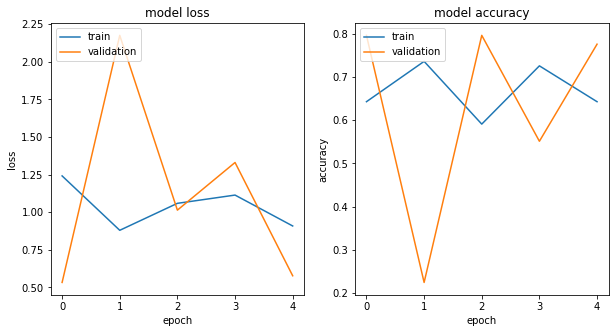

In [62]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))
    
    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history["val_{}".format(key)])
        plt.title("model {}".format(key))
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left");

plot_curves(history, ["loss", "accuracy"])

**Key note**: you will typically see best results with deep learning with much larger and more complex data sets. 